In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import netwulf as nw
from bs4 import BeautifulSoup
from networkx.algorithms import community
from community import community_louvain
import matplotlib.pyplot as plt

In [2]:
clean_answers_df = pd.read_csv('no_NA_Answers.csv', encoding='ISO-8859-1')
clean_questions_df = pd.read_csv('no_NA_Questions.csv', encoding='ISO-8859-1')

In [6]:
print(len(clean_answers_df.index))
print(len(clean_questions_df.index))
unique_users = np.unique([x for x in np.unique(clean_questions_df.get('OwnerUserId')+clean_answers_df.get('OwnerUserId'))])
print(f'unique_nodes: {len(unique_users)}')

2001316
1249762
unique_nodes: 1139798


In [8]:
unique_user_ids = np.asarray(np.asarray(np.unique(clean_answers_df.get('OwnerUserId')+clean_answers_df.get('OwnerUserId')),dtype=int),dtype=str)
pd.isna(np.asarray(np.unique(clean_answers_df.get('OwnerUserId')+clean_answers_df.get('OwnerUserId')),dtype=int)).any() #check if any NAN - should be false

False

In [10]:
G = nx.DiGraph()
G.add_nodes_from(unique_user_ids)

In [18]:
owner_attrs = {}

owner_found_bool = {}
#Add question/owner attributes to nodes:
for i in range(len(clean_questions_df.get('OwnerUserId'))):
    question_id = str(clean_questions_df.iloc[i].get('Id'))
    owner_id = str(int(clean_questions_df.iloc[i].get('OwnerUserId')))
    if not owner_found_bool.get(owner_id):
        owner_found_bool[owner_id] = True
        owner_attrs[owner_id] = {}
        owner_attrs[owner_id]['scores'] = {}
    owner_attrs[owner_id][question_id] = BeautifulSoup(clean_questions_df.iloc[i].get('Body'), 'html.parser').get_text()
    owner_attrs[owner_id]['scores'][question_id] = (clean_questions_df.iloc[i].get('Score'))    
    #Should also save question title in graph - implement here:
    

    if i % 50000 == 0:
        print(i)


0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
1200000


In [19]:
answers_attrs = {}
answers_found_bool = {}

collab_network = {}

#Add answer attributes to nodes & remember that edge is directed from OwnerUserId --> ParentId:
for i in range(len(clean_answers_df.get('OwnerUserId'))):
    answers_id = str(clean_answers_df.iloc[i].get('Id'))
    owner_id = str(int(clean_answers_df.iloc[i].get('OwnerUserId')))
    parent_id = str(int(clean_answers_df.iloc[i].get('ParentId')))
    if not answers_found_bool.get(owner_id):
        answers_found_bool[owner_id] = True
        answers_attrs[owner_id] = {}
    if not owner_found_bool.get(owner_id):
        owner_found_bool[owner_id] = True
        owner_attrs[owner_id] = {}
        owner_attrs[owner_id]['scores'] = {}

    owner_attrs[owner_id][answers_id] = BeautifulSoup(clean_answers_df.iloc[i].get('Body'), 'html.parser').get_text()
    
    if not collab_network.get((owner_id, parent_id)):
        collab_network[(owner_id, parent_id)] = 1
    else:
        collab_network[(owner_id, parent_id)] += 1

    #we want to find scores for each person for answers too.
    owner_attrs[owner_id]['scores'][answers_id] = clean_answers_df.iloc[i].get('Score')
    if i % 50000 == 0:
        print(i)

nx.set_node_attributes(G, answers_attrs, 'Questions')

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
1200000
1250000
1300000
1350000
1400000
1450000
1500000
1550000
1600000
1650000
1700000
1750000
1800000
1850000
1900000
1950000
2000000


In [20]:
#make edgelist and then edges in network.
edgelist = [(x[0][0], x[0][1], x[1]) for x in collab_network.items()]

G.add_weighted_edges_from(edgelist)

In [21]:
print(f'Number of nodes in G: {G.number_of_nodes()}')
print(f'Number of edges in G: {G.number_of_edges()}')
print(f'Edges for node 61 in G: {G.edges(str(61))}')

print(f'Info about Node 61 in G: {G.nodes[str(61)]}')


Number of nodes in G: 1975473
Number of edges in G: 1993272
Edges for node 61 in G: [('61', '90'), ('61', '24270'), ('61', '47980'), ('61', '51390'), ('61', '142340'), ('61', '526660'), ('61', '1581560'), ('61', '2520220'), ('61', '6242540'), ('61', '6553950')]
Info about Node 61 in G: {}


In [29]:
G = G.to_undirected()

In [30]:
best_partition = community_louvain.best_partition(G)
communities_generator = community.girvan_newman(G)

num_communities:515686 


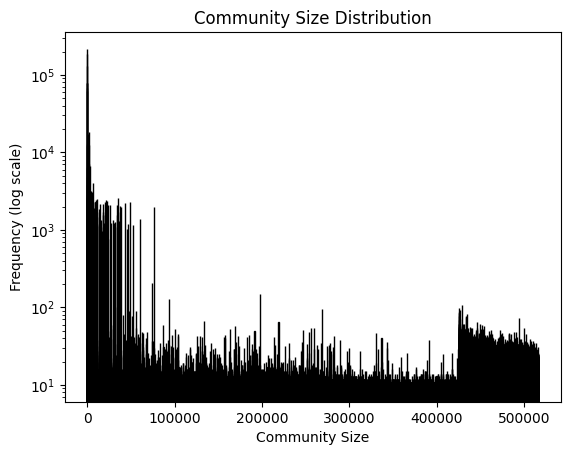

In [48]:
print(f'num_communities:{max(best_partition.values()) + 1} ')

plt.hist(best_partition.values(), bins = 50000,ec="black")
plt.title('Community Size Distribution')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.xlabel('Community Size')
plt.show()

In [ ]:
from matplotlib import colors as colors

num_communities = max(best_partition.values()) + 1
community_colors = {i: f'#{j:x}' for i, j in zip(range(num_communities), np.random.randint(256**3, size=num_communities))}

node_colors = [community_colors[best_partition[node]] for node in G.nodes()]
config = { "Node color": node_colors, "Node size": 1, "Node stroke width": 0, "Edge width": 1,"Zoom": 0.5,}
#nw.visualize(G)

#Visualize network
best_partition = community_louvain.best_partition(G)
sizes = [len(c) for c in best_partition]
G_where = np.array(G.nodes)

degreeColor = np.empty(len(G_where), dtype=object)
valueToPlot = np.log10(sizes)

valueToPlotRescaled = 255*(valueToPlot - np.min(valueToPlot))/np.max(valueToPlot)

for size, c in zip(sizes, best_partition):
    for node in c:
        color = '#%02x%02x%02x' % (int(size), 0, 50)
        degreeColor[np.where(G_where == node)] = color
dictionaryColor = dict(zip(list(G.nodes), degreeColor))
for node, group in dictionaryColor.items():
    dictionaryColor[node] = str(group)
nx.set_node_attributes(G, dictionaryColor, 'group')